    Time Quota  Partition(%)  Throughput(req/s)
0          0.2           100          21.885272
1          0.2            12          17.338712
2          0.2            24          24.423978
3          0.2            50          20.459590
4          0.2             6          12.550502
5          0.4           100          33.577768
6          0.4            12          34.678584
7          0.4            24          29.066030
8          0.4            50          36.573150
9          0.4             6          17.994238
10         0.6           100          45.703926
11         0.6            12          42.158863
12         0.6            24          33.891058
13         0.6            50          46.920473
14         0.6             6          28.313419
15         0.8           100          59.820778
16         0.8            12          47.788106
17         0.8            24          57.740987
18         0.8            50          54.181279
19         0.8             6          35

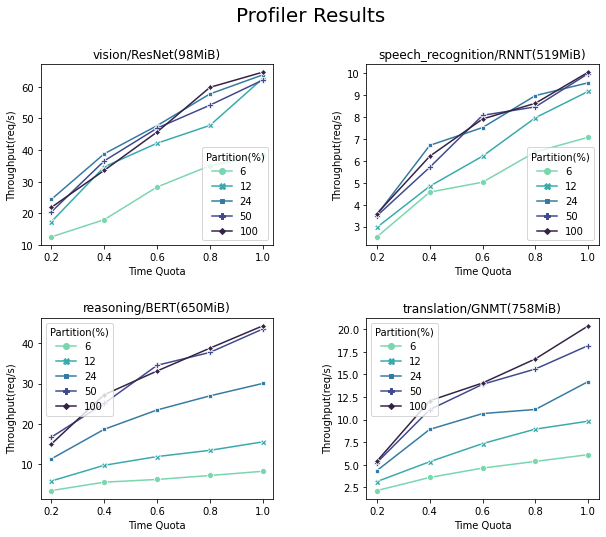

In [2]:
import pandas as pd
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

def getDFfromCSV(file):
    csv = pd.read_csv(file)
    quota=[]
    sm=[]
    key=[]
    for index, row in csv.iterrows():
        limit_json = json.loads(row["limitations"])
        metrics_json = json.loads(row["other_metrics"])

        quota.append(float(limit_json['GPU_QUOTA']))
        sm.append(int(limit_json['GPU_SM']))
        key.append(float(row["value"]))

    dfdata = pd.DataFrame({'Time Quota':quota, 'Partition(%)':sm, 'Throughput(req/s)':key})
    print(dfdata)
    df = dfdata.groupby(['Time Quota', 'Partition(%)']).agg({'Throughput(req/s)': 'max'}).reset_index()
    df = df[df['Throughput(req/s)'] != -1]
    return df


rsnt = getDFfromCSV('fnl-rsnt4.csv')
bert = getDFfromCSV('fnl-bert.csv')
gnmt = getDFfromCSV('fnl-gnmt.csv')
rnnt = getDFfromCSV('fnl-rnnt.csv')

palette = sns.color_palette("mako_r", 5)

fig, axs = plt.subplots(2, 2, figsize=(10, 8))

def drawsubplot(df, ax, model):
    sns.lineplot(x='Time Quota', y='Throughput(req/s)', hue='Partition(%)', data=df, style="Partition(%)",
        markers=True, dashes=False,
        palette=palette,
        ax=ax
        )
    ax.set_title(model)
drawsubplot(rsnt, axs[0,0],"vision/ResNet(98MiB)")
drawsubplot(rnnt, axs[0,1],"speech_recognition/RNNT(519MiB)")
drawsubplot(bert, axs[1,0],"reasoning/BERT(650MiB)")
drawsubplot(gnmt, axs[1,1],"translation/GNMT(758MiB)")

fig.suptitle('Profiler Results', fontsize=20)
fig.subplots_adjust(hspace=0.4, wspace=0.4)
plt.savefig("Profiler.svg", format="svg")
